# HW 3: Protecting whales from ships
#### By Mia Forsline and Alex Yousefivand 
#### EDS 223: Spatial Analysis 
#### Due 2021-11-16 

# Introduction
In the Caribbean island nation of Dominica,  whale watching tourism is an important portion of Dominica's ecotourism. However, sperm whale habitat and marine vessel traffic often spatially overlap and can lead to vessel strikes. To mitigate the risk of such collisions, one solution is to introduce a speed reduction zone in which ships are required to trael 10 knots of slower. 

Here, we use whale sighting data from 2005 - 2018 and Automatic Identification System (AIS) transmitter locational data to create a map of a proposed speed reduction zone in sperm whale habitat with frequent sightings. AIS data is for commercial vessels and any vessels of at least 300 gross tonnage. Frequent whale sightings are defined as more than 20 whale sightings per cell. We also quantify how much time ships may be losing if they abide by the 10 knot speed limit within the zone. 

This data is based on work done by the [Worthwhale MESM group project](https://worthwhale.weebly.com/our-project.html) and the [Benioff Ocean Initiative's Whale Safe Project](https://whalesafe.com/about-us/). 

# Import necessary libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
%matplotlib inline

# Dominica outline
- read in Dominica outline shapefile using `geopandas` 
- change Dominica shapefile CRS from WGS 84 to a Dominica-appropriate CRS such as EPSG 4602 (units: degrees) or EPSG 2002 (units: meters)
    - to plot the outline of the country, we will use EPSG 4602

In [2]:
fp = "data/dominica/dma_admn_adm0_py_s1_dominode_v2.shp"
dominica = gpd.read_file(fp)
dominica.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
dominica = dominica.to_crs(crs="EPSG:4602")
dominica.crs

<Geographic 2D CRS: EPSG:4602>
Name: Dominica 1945
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Dominica - onshore.
- bounds: (-61.55, 15.14, -61.2, 15.69)
Datum: Dominica 1945
- Ellipsoid: Clarke 1880 (RGS)
- Prime Meridian: Greenwich

## Plot Dominica outline for exploration 

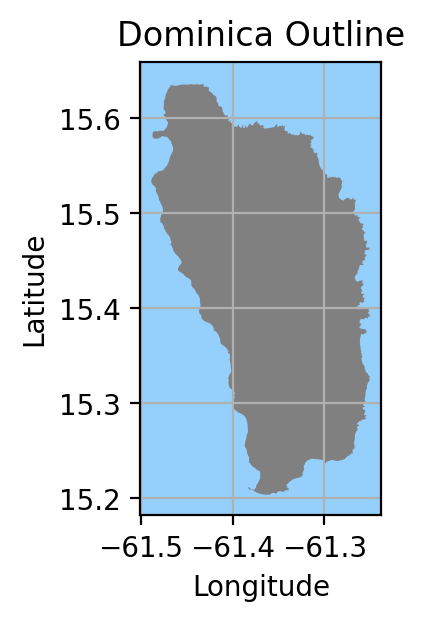

In [4]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
ax.grid(True)

dominica.plot(ax=ax, legend = True, facecolor = "gray")

ax.set_title("Dominica Outline")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_facecolor('xkcd:light blue')

# Whale sighting data (2005 - 2018)  
## Read in whale data
- Note: the CSV data is missing a geometry and thus has no CRS 

In [5]:
fp = "data/sightings2005_2018.csv"
whale = gpd.read_file(fp)
whale.head()

,field_1,GPStime,Lat,Long,geometry
0,0,2005-01-15 07:43:27,15.36977117,-61.49328433,None
1,1,2005-01-15 08:07:13,15.3834075,-61.503702,None
2,2,2005-01-15 08:31:17,15.38106333,-61.50486067,None
3,3,2005-01-15 09:19:10,15.33532083,-61.46858117,None
4,4,2005-01-15 10:08:00,15.294224,-61.45318517,None


## Generate GeometryArray of shapely point geometries from x,y coordinates
- geometry CRS is in WGS 84

In [6]:
geometry = gpd.points_from_xy(whale.Long, whale.Lat, crs = "EPSG:4326")
geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Add geometry to whale dataset 
- check the whale data now has geometry data in the `geometry` column 
- convert whale data CRS to EPSG 2002
    - check that the geometry is now in meters, not degrees, in order to create the grid 

In [7]:
whale_geom = whale.set_geometry(geometry)
whale_geom.head()

,field_1,GPStime,Lat,Long,geometry
0,0,2005-01-15 07:43:27,15.36977117,-61.49328433,POINT (-61.49328 15.36977)
1,1,2005-01-15 08:07:13,15.3834075,-61.503702,POINT (-61.50370 15.38341)
2,2,2005-01-15 08:31:17,15.38106333,-61.50486067,POINT (-61.50486 15.38106)
3,3,2005-01-15 09:19:10,15.33532083,-61.46858117,POINT (-61.46858 15.33532)
4,4,2005-01-15 10:08:00,15.294224,-61.45318517,POINT (-61.45319 15.29422)


In [8]:
whale_geom = whale_geom.to_crs("EPSG:2002")
whale_geom.head()

,field_1,GPStime,Lat,Long,geometry
0,0,2005-01-15 07:43:27,15.36977117,-61.49328433,POINT (453414.693 1698559.951)
1,1,2005-01-15 08:07:13,15.3834075,-61.503702,POINT (452293.279 1700065.539)
2,2,2005-01-15 08:31:17,15.38106333,-61.50486067,POINT (452169.541 1699805.987)
3,3,2005-01-15 09:19:10,15.33532083,-61.46858117,POINT (456075.021 1694756.090)
4,4,2005-01-15 10:08:00,15.294224,-61.45318517,POINT (457738.945 1690214.877)


## Create sampling grid using the total_bounds attribute 
- check that the total_bounds are in meters, not degrees
- create the empty grid shapefile with cell sizes of 2000m x 2000m 
- read in grid shapefile to check CRS is EPSG 2002 (units: meters) 

In [9]:
tb = whale_geom.total_bounds
tb

array([ 408480.65208369, 1532792.74594092,  498500.30495702,
       1796964.39970292])

In [10]:
xmin, ymin, xmax, ymax = whale_geom.total_bounds

length = 2000
wide = 2000

cols = list(np.arange(xmin, xmax + wide, wide))
rows = list(np.arange(ymin, ymax + length, length))

cells = []
for x in cols[:-1]:
    for y in rows[:-1]:
        cells.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':cells})
grid.to_file("grid.shp")

In [11]:
fp = "grid.shp"

grid = gpd.read_file(fp)
grid = grid.set_crs("EPSG:2002")
grid = grid.to_crs("EPSG:2002")
grid.crs

<Projected CRS: EPSG:2002>
Name: Dominica 1945 / British West Indies Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Dominica - onshore.
- bounds: (-61.55, 15.14, -61.2, 15.69)
Coordinate Operation:
- name: British West Indies Grid
- method: Transverse Mercator
Datum: Dominica 1945
- Ellipsoid: Clarke 1880 (RGS)
- Prime Meridian: Greenwich

## Visually examine empty sample grid 

<AxesSubplot:>

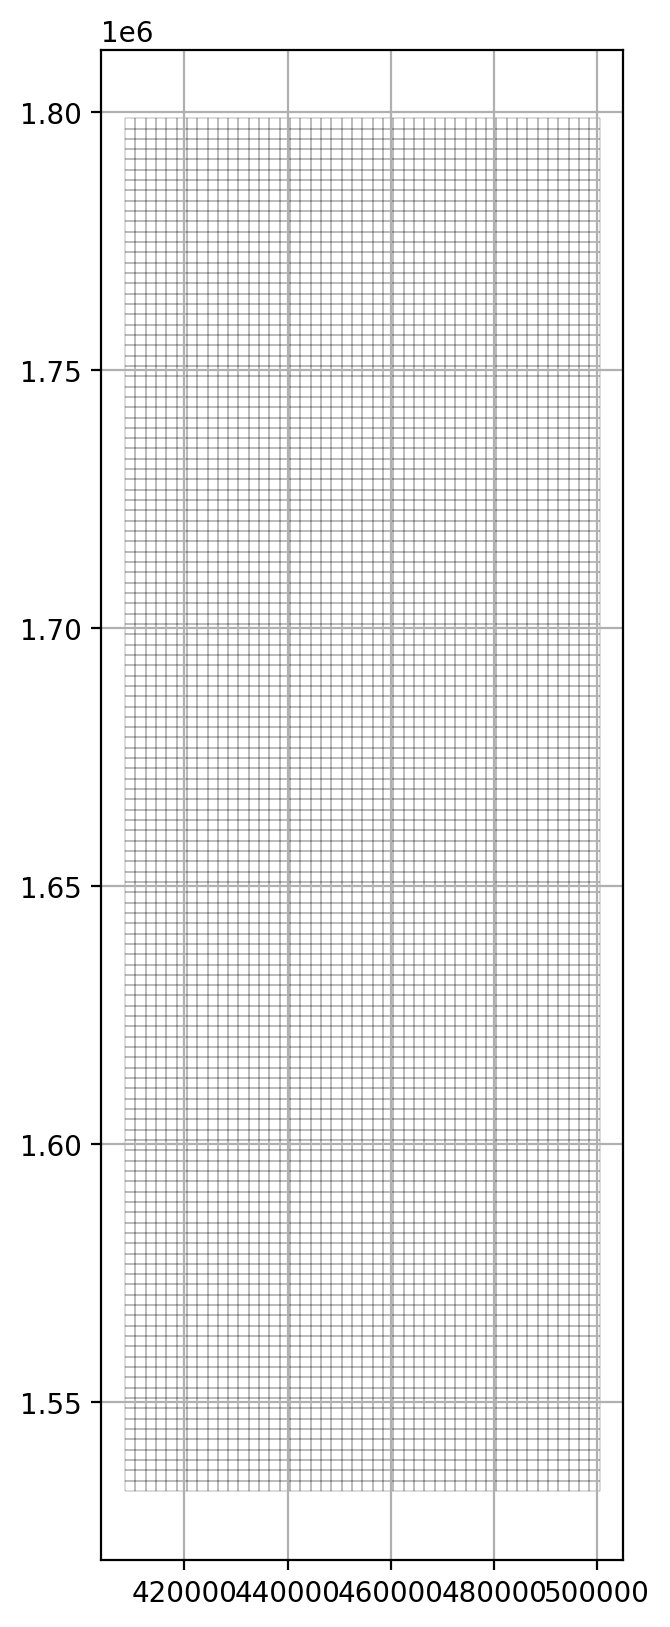

In [12]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=200)
ax.grid(True)

grid.plot(ax=ax, 
          facecolor = "none",
          lw = 0.1)

## Extract whale habitat using a spatial join 
- use an inner join to extract only grid cells with whale sightings 
- use a *map-reduce* operation to count whale sightings per cell 
- add a new column `count` to the grid dataframe in order to store the number of sightings 
 - we don't want a redundant count in every column 
- include only cells that have more than 20 whale sightings 
    - check that the minimum number of whale sightings > 20  

In [13]:
#note: starting w/whale_geom does not work; whale_geom should be the argument of this function
grid_join = grid.sjoin(whale_geom, how = "inner")
grid_join.head()

,FID,geometry,index_right,field_1,GPStime,Lat,Long
124,124,"POLYGON ((408480.652 1780792.746, 408480.652 1...",4327,4327,2018-03-15 06:41:03,16.127,-61.896866
124,124,"POLYGON ((408480.652 1780792.746, 408480.652 1...",4328,4328,2018-03-15 06:44:05,16.127666,-61.900766
124,124,"POLYGON ((408480.652 1780792.746, 408480.652 1...",4329,4329,2018-03-15 06:58:17,16.1305,-61.903366
125,125,"POLYGON ((408480.652 1782792.746, 408480.652 1...",4330,4330,2018-03-15 07:15:33,16.139583,-61.900116
125,125,"POLYGON ((408480.652 1782792.746, 408480.652 1...",4331,4331,2018-03-15 07:17:30,16.14175,-61.897716


In [14]:
grid_join.groupby(grid_join.index).count()

,FID,geometry,index_right,field_1,GPStime,Lat,Long
124,3,3,3,3,3,3,3
125,2,2,2,2,2,2,2
129,5,5,5,5,5,5,5
131,1,1,1,1,1,1,1
132,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
5131,1,1,1,1,1,1,1
5132,1,1,1,1,1,1,1
5133,2,2,2,2,2,2,2
5134,1,1,1,1,1,1,1


In [15]:
grid['count'] = grid_join.groupby(grid_join.index).count()['index_right']
grid = grid.loc[(grid['count'] > 20)]
grid['count'].min()

21.0

## Create the convex hull
- use `unary_union` to create a MultiPolygon containing the union of all geometries in the `GeoSeries`
- create the convex hull 
    - shape should differ from the `unary_union` 
- change the `GeoSeries` to a `GeoDataFrame`
- set CRS to plot 

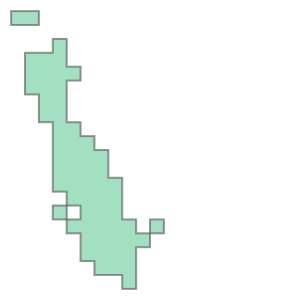

In [16]:
union = grid.unary_union
union

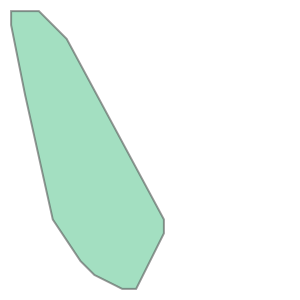

In [17]:
ch = union.convex_hull
ch

In [18]:
ch_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(ch))
ch_gdf = ch_gdf.set_crs(crs="EPSG:2002")
ch_gdf = ch_gdf.to_crs(crs="EPSG:2002")

## Plot grid, whale sightings, and Dominica outline together 
- change Dominica outline CRS to EPSG 2002 (units: meters) to plot with the grid and convex hull 
- Note: one of the sighting cells overlaps with the land

In [19]:
dominica_m = dominica.to_crs(crs="EPSG:2002")

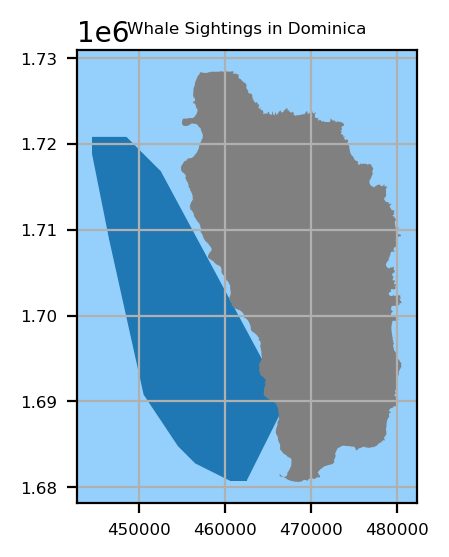

In [20]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=200)
ax.grid(True)

grid.plot(ax=ax, legend = True)
ch_gdf.plot(ax = ax)
dominica_m.plot(ax=ax, facecolor = "gray")

ax.set_title("Whale Sightings in Dominica", fontsize = 6)
ax.tick_params(labelsize = 6)
ax.set_facecolor('xkcd:light blue')

# Vessel Data
## Load Station 1249 data from 2015 
- generate and add geometries to vessel data 
    - note geometries are in WGS 84 
- change `TIMESTAMP` column into datetime format 
- set CRS to EPSG 2002
- inner join the vessel data and convex hull (speed reduction zone) in order to keep only data from vessels within the area of interest 
    - we don't need data from vessels not within the speed reduction zone 

In [21]:
fp = "data/station1249.csv"
station = gpd.read_file(fp)
station.head(3)

,field_1,MMSI,LON,LAT,TIMESTAMP,geometry
0,0,233092000,-61.84788,15.23238,2015-05-22 13:53:26,None
1,1,255803280,-61.74397,15.96114,2015-05-22 13:52:57,None
2,2,329002300,-61.38968,15.29744,2015-05-22 13:52:32,None


In [22]:
geometry = gpd.points_from_xy(station.LON, station.LAT, crs="EPSG:4326")
geometry.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
station_geom = station.set_geometry(geometry)
station_geom.head(3)

,field_1,MMSI,LON,LAT,TIMESTAMP,geometry
0,0,233092000,-61.84788,15.23238,2015-05-22 13:53:26,POINT (-61.84788 15.23238)
1,1,255803280,-61.74397,15.96114,2015-05-22 13:52:57,POINT (-61.74397 15.96114)
2,2,329002300,-61.38968,15.29744,2015-05-22 13:52:32,POINT (-61.38968 15.29744)


In [24]:
station_geom['TIMESTAMP'] = pd.to_datetime(station_geom['TIMESTAMP'])

In [25]:
sg = station_geom.to_crs(crs = "EPSG:2002")

In [26]:
vessel_whale = sg.sjoin(ch_gdf, how = 'inner')
vessel_whale.shape #167,411 rows

(167411, 7)

## Calculate distance and speed
- sort data by Maritime Mobile Service Identity (`MMSI`) and time 
- create a copy of the data shifted one row down 
- join the original and copy together 
- drop rows in which `MMSI_future` ≠ `MMSI_now`

In [27]:
vessel_whale = vessel_whale.sort_values(by=['MMSI', 'TIMESTAMP'])

In [28]:
vw_shift = vessel_whale.shift(periods = 1)
vw_shift.head(3)

,field_1,MMSI,LON,LAT,TIMESTAMP,geometry,index_right
235025,NaN,NaN,NaN,NaN,NaT,None,NaN
235018,235025,203106200,-61.40929,15.21021,2015-02-25 15:32:20,POINT (462476.396 1680935.224),0.0
235000,235018,203106200,-61.41107,15.21436,2015-02-25 15:34:50,POINT (462283.995 1681393.698),0.0


In [29]:
vw_join = vessel_whale.join(vw_shift, lsuffix = "_future")
vw_join.head(3)

,field_1_future,MMSI_future,LON_future,LAT_future,TIMESTAMP_future,geometry_future,index_right_future,field_1,MMSI,LON,LAT,TIMESTAMP,geometry,index_right
235025,235025,203106200,-61.40929,15.21021,2015-02-25 15:32:20,POINT (462476.396 1680935.224),0,NaN,NaN,NaN,NaN,NaT,None,NaN
235018,235018,203106200,-61.41107,15.21436,2015-02-25 15:34:50,POINT (462283.995 1681393.698),0,235025,203106200,-61.40929,15.21021,2015-02-25 15:32:20,POINT (462476.396 1680935.224),0.0
235000,235000,203106200,-61.41427,15.22638,2015-02-25 15:42:19,POINT (461936.769 1682722.187),0,235018,203106200,-61.41107,15.21436,2015-02-25 15:34:50,POINT (462283.995 1681393.698),0.0


In [30]:
vw_sub = vw_join.loc[(vw_join['MMSI_future'] == vw_join['MMSI'])]
vw_sub.head(3)
vw_sub.shape

(166255, 14)

### For each row, calculcate:
- distance in meters between each observation and the next (`dist_m`)
- time difference in seconds between each observation and the next (`sec_diff`)
- average speed (m/sec) between each observation and the next (`m_per_sec`)
- time in seconds that the distance would have taken at a speed of 10 knots (`10_knots_time_sec`)
- the time difference in seconds between the actual time and the time it would have taken at a speed of 10 knots (`time_diff`)

In [31]:
vw_sub['dist_m'] = vw_sub['geometry_future'].distance(vw_sub['geometry'])
vw_sub.head()

vw_sub['time_delta_sec'] = vw_sub['TIMESTAMP_future'] - vw_sub['TIMESTAMP']
vw_sub['sec_diff'] = (vw_sub['TIMESTAMP_future'] - vw_sub['TIMESTAMP']).dt.total_seconds()

vw_sub['m_per_sec'] = vw_sub['dist_m'] / vw_sub['time_delta_sec'].dt.total_seconds()

ten_knots = 5.14444
vw_sub['ten_knots_time_sec'] = vw_sub['dist_m'] / ten_knots

vw_sub['time_diff'] = vw_sub['ten_knots_time_sec'] - vw_sub['sec_diff']

vw_sub.head()

C:\Users\Alex Vand\.conda\envs\eds223\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Alex Vand\.conda\envs\eds223\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,field_1_future,MMSI_future,LON_future,LAT_future,TIMESTAMP_future,geometry_future,index_right_future,field_1,MMSI,LON,LAT,TIMESTAMP,geometry,index_right,dist_m,time_delta_sec,sec_diff,m_per_sec,ten_knots_time_sec,time_diff
235018,235018,203106200,-61.41107,15.21436,2015-02-25 15:34:50,POINT (462283.995 1681393.698),0,235025,203106200,-61.40929,15.21021,2015-02-25 15:32:20,POINT (462476.396 1680935.224),0.0,497.209041,0 days 00:02:30,150.0,3.314727,96.649789,-53.350211
235000,235000,203106200,-61.41427,15.22638,2015-02-25 15:42:19,POINT (461936.769 1682722.187),0,235018,203106200,-61.41107,15.21436,2015-02-25 15:34:50,POINT (462283.995 1681393.698),0.0,1373.116137,0 days 00:07:29,449.0,3.058165,266.912655,-182.087345
234989,234989,203106200,-61.41553,15.2353,2015-02-25 15:47:19,POINT (461798.818 1683708.377),0,235000,203106200,-61.41427,15.22638,2015-02-25 15:42:19,POINT (461936.769 1682722.187),0.0,995.792381,0 days 00:05:00,300.0,3.319308,193.566721,-106.433279
234984,234984,203106200,-61.41687,15.23792,2015-02-25 15:49:50,POINT (461654.150 1683997.765),0,234989,203106200,-61.41553,15.2353,2015-02-25 15:47:19,POINT (461798.818 1683708.377),0.0,323.533223,0 days 00:02:31,151.0,2.142604,62.889882,-88.110118
234972,234972,203106200,-61.41851,15.24147,2015-02-25 15:54:49,POINT (461476.997 1684389.925),0,234984,203106200,-61.41687,15.23792,2015-02-25 15:49:50,POINT (461654.150 1683997.765),0.0,430.317090,0 days 00:04:59,299.0,1.439188,83.647023,-215.352977


## Find the sum of all time differences > 0
- we want to estimate how a 10-knot reduced-speed-zone might impact shipping by increasing travel time in whale habitat (`days_sum`) 

In [32]:
time_sum = vw_sub['time_diff']
time_sum = time_sum.loc[(time_sum > 0)]
#time_sum.min() check that min > 0 
sec_sum = time_sum.sum()
sec_sum
min_sum = sec_sum / 60
hrs_sum = min_sum / 60
days_sum = hrs_sum / 24
days_sum

27.87610664150381

# Conclusion

In Dominica, if we were to propose a speed reduction zone in which ships had to travel 10 knots, we would cause an increase in travel time of {{days_sum}} approximately 27.9 days. This estimation assumes constant ship speeds and that ships would travel exactly 10 knots within the whale habitat. 

Although a rough estimation, this is a valuable first step towards quantifying the impacts of sperm whale conservation efforts in order to enact meaningful policy change. Future directions could entail exploring whether 20 sightings per cell is an appropriate way to categorize whale habitat from non-whale-habitat. For example, maybe 20 sightings per 2km x 2km cell is too high or too low to best capture whale distributions. Or perhaps it would be helpful to take into account how long sightings were. Habitat with 5 10-minute long whale sightings might be more valuable to protect than habitat with 5 1-minute long whale sightings. 